In [1]:
import numpy as np

import cv2
import matplotlib.pyplot as plt

from datetime import datetime as time

In [2]:
%reload_ext autoreload
%autoreload 2

In [ ]:
img = cv2.imread("assets/city.jpg", cv2.IMREAD_UNCHANGED)[..., ::-1]

In [16]:
kernel_size = 5

t1 = time.now()
filtered_opencv = cv2.medianBlur(img, kernel_size)
time_ms_opencv = (time.now()-t1).microseconds/1000
filtered_opencv.shape

(333, 500, 3)

### Простая имплементация через циклы

In [17]:
def median_filter_naive(img, kernel_size):
    t1 = time.now()
    assert kernel_size % 2 != 0, "Kernel size should be odd"

    H, W, C_in = img.shape
    pad = (kernel_size - 1) // 2
    padded_img = np.pad(img, ((pad, pad), (pad, pad), (0, 0)), mode="edge")
    out = np.zeros_like(img)
    for c in range(C_in):
        for i in range(H):
            for j in range(W):
                window = padded_img[i:i+kernel_size, j:j+kernel_size, c]
                out[i, j, c] = np.median(window.flatten())
    t2 = time.now()
    return out.astype(np.uint8), (t2-t1).microseconds/1000

In [18]:
filtered_naive, time_ms_naive = median_filter_naive(img, kernel_size)
filtered_naive.shape, time_ms_naive

((333, 500, 3), 120.451)

In [19]:
np.testing.assert_almost_equal(filtered_opencv, filtered_naive)

### Имплементация через im2col

In [20]:
def im2col_3d(im, kernel_size):
    H, W, C_in = im.shape
    im = np.transpose(im, (2, 0, 1))
    HH = H - kernel_size + 1
    WW = W - kernel_size + 1

    rows = np.empty(shape=(kernel_size*kernel_size, C_in*HH*WW))

    for c in range(C_in):
        for hh in range(HH):
            for ww in range(WW):
                window = im[c, hh:hh+kernel_size, ww:ww+kernel_size]
                rows[:, (c*HH + hh)*WW + ww] = window.flatten()
    return rows.astype(np.uint8)


In [21]:
def median_filter_im2col(img, kernel_size):
    t1 = time.now()
    assert kernel_size % 2 != 0, "Kernel size should be odd"

    H, W, C_in = img.shape
    pad = (kernel_size - 1) // 2
    padded_img = np.pad(img, ((pad, pad), (pad, pad), (0, 0)), mode="edge")

    rows = im2col_3d(padded_img, kernel_size)
    median_rows = np.median(rows, axis=0)
    median_img = median_rows.reshape((C_in, H, W)).transpose((1, 2, 0))
    t2 = time.now()
    return median_img.astype(np.uint8), (t2-t1).microseconds/1000

In [22]:
filtered_im2col, time_ms_im2col = median_filter_im2col(img, kernel_size)
time_ms_im2col

320.741

### Сравнение

In [23]:
np.testing.assert_almost_equal(filtered_opencv, filtered_im2col)

In [24]:
np.testing.assert_almost_equal(filtered_opencv, filtered_naive)

(-0.5, 499.5, 332.5, -0.5)

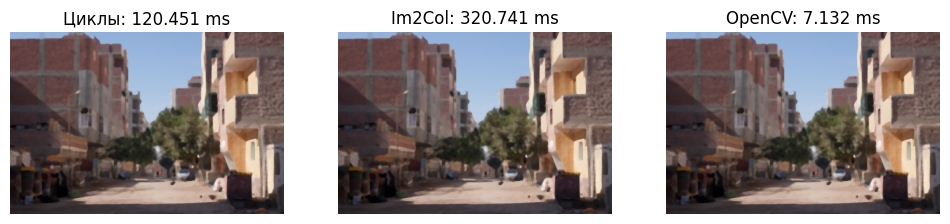

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(12, 10))
axes[0].imshow(filtered_naive)
axes[0].set_title(f"Циклы: {time_ms_naive:.3f} ms")
axes[0].axis("off")

axes[1].imshow(filtered_im2col)
axes[1].set_title(f"Im2Col: {time_ms_im2col:.3f} ms")
axes[1].axis("off")


axes[2].imshow(filtered_opencv)
axes[2].set_title(f"OpenCV: {time_ms_opencv:.3f} ms")
axes[2].axis("off")

# plt.savefig(f"assets/comparison.png", bbox_inches="tight")

## Разные размерности

In [35]:
scale = (1/8, 1/4, 1/2, 1, 2, 3, 4)

In [36]:
timers = {
    "naive": [],
    "im2col": [],
    "opencv": [],
}

shapes = []

repeats = 3
for s in scale:
    img_rsz = cv2.resize(img, dsize=None, fx=s, fy=s)
    shapes += [img_rsz.shape]

    t = []
    for _ in range(repeats):
        t1 = time.now()
        filtered_opencv = cv2.medianBlur(img_rsz, kernel_size)
        t += [(time.now()-t1).microseconds/1000]
    timers["opencv"] += [np.mean(t)]

    t = []
    for _ in range(repeats):
        filtered_naive, time_ms_naive = median_filter_naive(img_rsz, kernel_size)
        t += [time_ms_naive]
    timers["naive"] += [np.mean(t)]

    t = []
    for _ in range(repeats):
        filtered_im2col, time_ms_im2col = median_filter_im2col(img_rsz, kernel_size)
        t += [time_ms_im2col]
    timers["im2col"] += [np.mean(t)]

    print(f"Finished scale={s}")
    print(timers["opencv"][-1], timers["naive"][-1], timers["im2col"][-1])
    # break

Finished scale=0.125
0.207 159.249 18.832666666666668
Finished scale=0.25
0.48933333333333334 633.902 77.70833333333333
Finished scale=0.5
0.576 490.33933333333334 319.528
Finished scale=1
2.3516666666666666 621.225 253.20000000000002
Finished scale=2
5.554666666666667 482.27433333333335 654.495
Finished scale=3
10.212000000000002 696.0203333333333 228.97566666666668
Finished scale=4
16.693666666666665 423.41333333333336 638.005


Text(0.5, 0, 'scale')

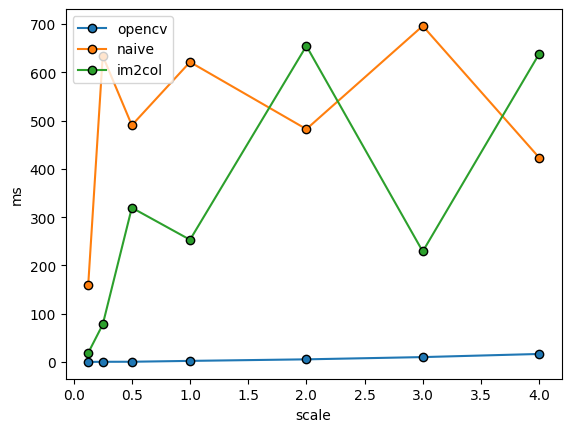

In [39]:
for k in ["opencv", "naive", "im2col"]:
    plt.plot(scale, timers[k], marker='o', markeredgecolor='k', label=k)
plt.legend(loc="upper left")
plt.ylabel("ms")
plt.xlabel("scale")